## Importamos la librerias

In [1]:
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models


## Preparamos los datos

In [3]:
# Directorios originales del dataset Fruits 360
original_train_dir = 'fruits/Training'
original_test_dir = 'fruits/Test'

# Crear nueva estructura para binario: "Orange" vs "NotOrange"
binary_dataset_dir = 'fruits_binary'
train_dir = os.path.join(binary_dataset_dir, 'Training')
test_dir = os.path.join(binary_dataset_dir, 'Test')

for split in ['Training', 'Test']:
    for cls in ['Orange', 'NotOrange']:
        os.makedirs(os.path.join(binary_dataset_dir, split, cls), exist_ok=True)


In [5]:
# Función para copiar imágenes a la estructura binaria
def copy_images(src_dir, dest_dir, positive_class='Orange 1'):
    for fruit in os.listdir(src_dir):
        fruit_path = os.path.join(src_dir, fruit)
        if not os.path.isdir(fruit_path):
            continue
        label = 'Orange' if fruit == positive_class else 'NotOrange'
        dest_path = os.path.join(dest_dir, label)
        for img in os.listdir(fruit_path):
            src_img = os.path.join(fruit_path, img)
            dst_img = os.path.join(dest_path, img)
            shutil.copyfile(src_img, dst_img)

# Copiar imágenes (ejecutar solo la primera vez o después de borrar fruits_binary)
copy_images(original_train_dir, train_dir)
copy_images(original_test_dir, test_dir)


In [7]:
# Parámetros
img_size = 160
batch_size = 32

# Normalización de imágenes
datagen = ImageDataGenerator(rescale=1./255)

# Cargar datos de entrenamiento y prueba
train_data = datagen.flow_from_directory(
    train_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='binary'
)

test_data = datagen.flow_from_directory(
    test_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='binary'
)


Found 2776 images belonging to 2 classes.
Found 1639 images belonging to 2 classes.


In [9]:
# Modelo base preentrenado
base_model = MobileNetV2(input_shape=(img_size, img_size, 3),
                         include_top=False,
                         weights='imagenet')
base_model.trainable = False  # Congelar pesos base

# Modelo final
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid')  # Salida binaria
])

# Compilar modelo
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


## Entrenamos el modelo

In [11]:
# Entrenamiento
epochs = 5  # Puedes subir a 10 o más si deseas
history = model.fit(
    train_data,
    validation_data=test_data,
    epochs=epochs
)


C:\Users\rodri\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
87/87 ━━━━━━━━━━━━━━━━━━━━ 86s 949ms/step - accuracy: 0.9553 - loss: 0.0747 - val_accuracy: 0.9963 - val_loss: 0.0097
Epoch 2/5
87/87 ━━━━━━━━━━━━━━━━━━━━ 64s 742ms/step - accuracy: 1.0000 - loss: 1.5307e-04 - val_accuracy: 0.9988 - val_loss: 0.0022
Epoch 3/5
87/87 ━━━━━━━━━━━━━━━━━━━━ 60s 687ms/step - accuracy: 1.0000 - loss: 1.5372e-04 - val_accuracy: 0.9982 - val_loss: 0.0067
Epoch 4/5
87/87 ━━━━━━━━━━━━━━━━━━━━ 54s 615ms/step - accuracy: 1.0000 - loss: 5.7142e-05 - val_accuracy: 0.9982 - val_loss: 0.0056
Epoch 5/5
87/87 ━━━━━━━━━━━━━━━━━━━━ 56s 647ms/step - accuracy: 1.0000 - loss: 4.1655e-05 - val_accuracy: 0.9982 - val_loss: 0.0052


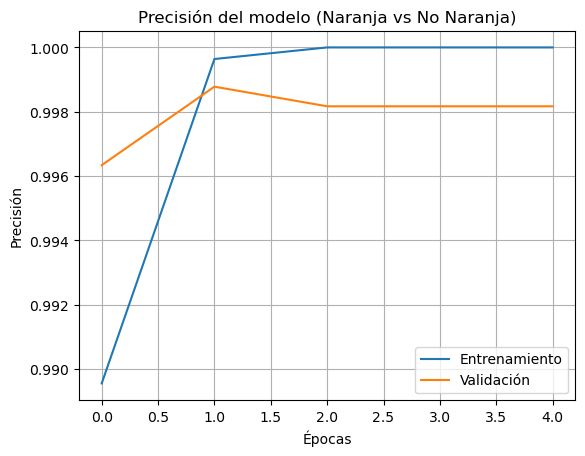

In [13]:
# Gráfica de precisión
plt.plot(history.history['accuracy'], label='Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Validación')
plt.title("Precisión del modelo (Naranja vs No Naranja)")
plt.xlabel("Épocas")
plt.ylabel("Precisión")
plt.legend()
plt.grid()
plt.show()


## Probamos el modelo

In [17]:
from tensorflow.keras.preprocessing import image

def predict_image(img_path):
    img = image.load_img(img_path, target_size=(img_size, img_size))
    img_array = image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) / 255.0  # Normalizar
    prediction = model.predict(img_array)[0][0]
    
    if prediction > 0.5:
        print(f"🌞 Es una naranja ({prediction:.2f})")
    else:
        print(f"🍏 No es una naranja ({1 - prediction:.2f})")

# Ejemplo de uso
predict_image('naranja.jpg')  # Cambia por la ruta real


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
🌞 Es una naranja (1.00)
